(513, 451)
(513, 451)


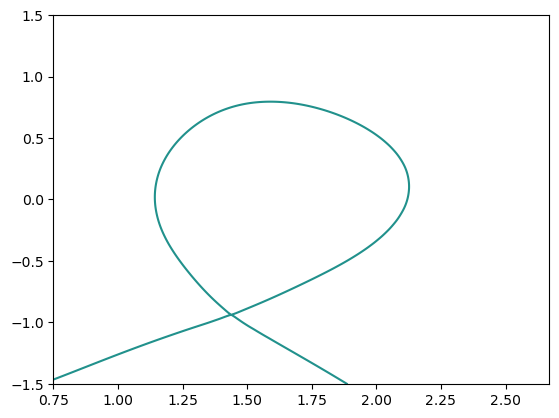

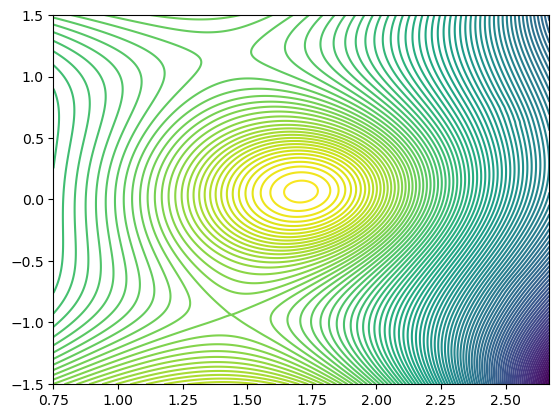

/tmp/ipykernel_967852/1745182510.py:48: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in contour.collections:


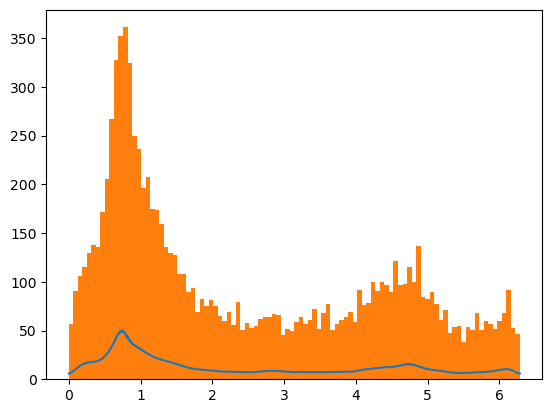

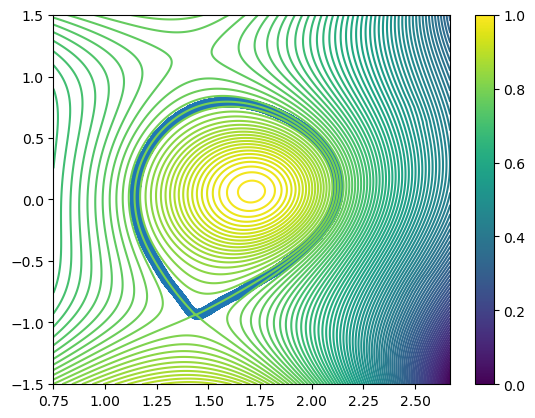

Data in folder!!!


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as fft


#Load fine grid data
psi_grid = np.loadtxt('./psi_p.dat')
R        = np.loadtxt('./R.dat')
Z        = np.loadtxt('./Z.dat')
Br       = np.loadtxt('./BR.dat')
Bz       = np.loadtxt('./Bz.dat')
print(np.shape(psi_grid))
# plt.figure()
# plt.contour(R_fine,Z_fine,psi_fine,100)
# plt.show()
# 
# psi_grid = np.loadtxt('/home/chaubrich/Downloads/eq/psi.dat')
# psi_grid = np.transpose(psi_grid)
# R = np.loadtxt('/home/chaubrich/Downloads/eq/R.dat')
# Z = np.loadtxt('/home/chaubrich/Downloads/eq/Z.dat')


#Br,Bz = np.gradient(psi_grid,R[1]-R[0],Z[1]-Z[0])

Bpol     = np.sqrt(Br**2 + Bz**2)

# plt.figure()
# plt.contourf(R,Z,Br,100)
# plt.show()

# plt.figure()
# plt.contourf(R,Z,Bz,100)
# plt.show()

print(np.shape(Bpol))

contour = plt.contour(R,Z,psi_grid, levels=0)

all_vertices = []

plt.figure()
plt.contour(R,Z,psi_grid,100)
plt.show()

# Loop through each collection in the contour
for collection in contour.collections:
    paths = collection.get_paths()  # Get paths for the current collection
    for path in paths:
        vertices = path.vertices  # Extract vertices from the path
        all_vertices.append(vertices)  # Store the vertices

LCFSs = all_vertices[0] #High resolution loader
#LCFS = all_vertices[1] #Low resolution loader

LCFS = [vertex for vertex in LCFSs if vertex[1] >= -0.95]

# If you want to convert LCFS back to a numpy array
LCFS = np.array(LCFS)

# Calculate uniform distribution of particles along LCFS
the  = np.linspace(0,2*np.pi,len(LCFS[:,0]))
Rfft = fft.rfft(LCFS[:,0])/len(LCFS[:,0])
Zfft = fft.rfft(LCFS[:,1])/len(LCFS[:,1]) 

Rc = Rfft.real
Zc = Zfft.real
Rs = Rfft.imag
Zs = Zfft.imag

RF = Rc[0]
ZF = Zc[0]
# Fourier sums of R(\theta) and Z(\theta)
for n in range(1,15): # Set Fourier mode number manually
    RF = RF + 2*(Rc[n]*np.cos(n*the) + Rs[n]*np.sin(n*the))
    ZF = ZF + 2*(Zc[n]*np.cos(n*the) + Zs[n]*np.sin(n*the))

dRdt = np.gradient(RF)
dZdt = np.gradient(ZF)

Jac = []

for bfindex in range(len(RF)):
    rb = np.argmin(abs(R-RF[bfindex]))
    zb = np.argmin(abs(Z-ZF[bfindex]))
    # print(Bpol[rb][zb])
    Jac.append((1/Bpol[rb][zb])*(np.sqrt(dRdt[bfindex]**2 + dZdt[bfindex]**2)))
Jmax = max(Jac)

# Load Particles
num_points = 10000
thetaidx   = []
m = 0

while m <= num_points:
    theta = random.uniform(0,2*np.pi)
    tdx = np.argmin(np.abs(the - theta))
    if random.uniform(0,1) < Jac[tdx]/Jmax:
        thetaidx.append(theta)
        m = m+1

rvalid = []
zvalid = []
for point in range(num_points):
    idx = np.argmin(np.abs(the - thetaidx[point]))
    rvalid.append(RF[idx])
    zvalid.append(ZF[idx])

plt.figure()
plt.plot(the,Jac/max(Jac)*50)
plt.hist(thetaidx,100)
plt.show()

plt.figure()
plt.contour(R,Z,psi_grid,100)
plt.scatter(rvalid,zvalid)
plt.colorbar()
plt.show()

rdata_file = "./rdata_highres.dat"
zdata_file = "./zdata_highres.dat"
dfr = pd.DataFrame(rvalid)
dfz = pd.DataFrame(zvalid)
dfr.to_csv(rdata_file, index=False, header=False)
dfz.to_csv(zdata_file, index=False, header=False)
print("Data in folder!!!")

